<a href="https://colab.research.google.com/github/ml-group8/assignment/blob/main/Stock_Price_Prediction_with_Sentiment_Analysis_Compare_Sentiment_and_Stock_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install yfinance

     |████████████████████████████████| 5.5MB 10.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=d6d86dc7d8f4fdb443877397a3e83d89ecb76334a3ca69ec40d68da4327fd6f5
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [58]:
import pandas as pd
import numpy as np
import requests
import json
import ast
import yaml
import urllib
import yfinance
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
#from google.colab import drive

In [29]:
df_tweets = pd.read_csv('https://raw.githubusercontent.com/ml-group8/assignment/main/df_tweets_sentiment.csv')
# Keep only required columns
df_tweets = df_tweets[['created_at', 'id', 'tweet', 'sentiment', 'confidence']]

# Convert created_at column from string to datetime
def string_to_datetime(str_date):
  str_date = str_date[:19]
  return datetime.strptime(str_date, "%Y-%m-%dT%H:%M:%S")

df_tweets['created_at'] = df_tweets['created_at'].map(lambda strDateTime: string_to_datetime(strDateTime))

max_date_tweets = df_tweets['created_at'].max().replace(minute=0, second=0, microsecond=0)
min_date_tweets = df_tweets['created_at'].min().replace(minute=0, second=0, microsecond=0)

#df_tweets
print(min_date_tweets)
print(max_date_tweets)

2021-03-13 17:00:00
2021-03-20 15:00:00


In [32]:
from datetime import datetime, timedelta, timezone

#A/p the yfinance docs, Note: yahoo finance datetimes are received as UTC.
#however when visualizing the df the Datetime field is UTC-4 ???
drive_etf_ticker = yfinance.Ticker("DRIV")
drive_etf = drive_etf_ticker.history(
    start=min_date.strftime('%Y-%m-%d'),
    end=max_date.strftime('%Y-%m-%d'),
    interval='60m'
).reset_index()

# The Yahoo finance are in EST so convert them to UTC to match the tweets' timezone
drive_etf['DatetimeUTC'] = drive_etf['Datetime'].dt.tz_convert('UTC')

#set new UTC datetime as the index, we can visually compare to the original column to see the timezone correction
drive_etf.index = drive_etf['DatetimeUTC']
del drive_etf['DatetimeUTC']

drive_etf.head()

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
DatetimeUTC,,,,,,,,
2021-03-15 13:30:00+00:00,2021-03-15 09:30:00-04:00,27.338800,27.450001,27.260000,27.389999,161430,0,0
2021-03-15 14:30:00+00:00,2021-03-15 10:30:00-04:00,27.409201,27.450001,27.270000,27.270000,47716,0,0
2021-03-15 15:30:00+00:00,2021-03-15 11:30:00-04:00,27.264400,27.320000,27.180000,27.299999,47115,0,0
2021-03-15 16:30:00+00:00,2021-03-15 12:30:00-04:00,27.306000,27.349501,27.299999,27.329000,26073,0,0
2021-03-15 17:30:00+00:00,2021-03-15 13:30:00-04:00,27.330000,27.429800,27.309999,27.419901,47720,0,0


In [33]:
# Remove the non-UTC Datetime
del drive_etf['Datetime']
drive_etf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
DatetimeUTC,,,,,,,
2021-03-15 13:30:00+00:00,27.338800,27.450001,27.260000,27.389999,161430,0,0
2021-03-15 14:30:00+00:00,27.409201,27.450001,27.270000,27.270000,47716,0,0
2021-03-15 15:30:00+00:00,27.264400,27.320000,27.180000,27.299999,47115,0,0
2021-03-15 16:30:00+00:00,27.306000,27.349501,27.299999,27.329000,26073,0,0
2021-03-15 17:30:00+00:00,27.330000,27.429800,27.309999,27.419901,47720,0,0


In [ ]:
# The stock market, unlike Twitter, is closed on weekend so we have gaps in our stock time series relative to our tweets
# We'll patch those gaps with interpolation
# TODO: Use after hours data if possible ???

#drive_etf.groupby('DatetimeUTC').resample('H')

In [67]:
# ETF 
# min: 2021-03-15 13:30
# max: 2021-03-19 19:30

# Tweets
# Min: 2021-03-13 17:00:02
# Max: 2021-03-20 15:59:46

# Convert sentiment to numeric (Positive=1, negative=0)
df_tweets['numeric_sentiment'] = np.where(df_tweets['sentiment'] == 'POSITIVE', 1, 0)

# Truncate created_at to the hour
df_tweets['created_at'] = df_tweets['created_at'].map(lambda created_at: created_at.replace(minute=0, second=0, microsecond=0))

df_tweets
df_grouped = df_tweets.groupby(["created_at", "numeric_sentiment"]).size()
#df_grouped['positive'] = np.where(df_grouped['numeric_sentiment'] == 1, 1, 0)
#df_grouped['negative'] = np.where(df_grouped['numeric_sentiment'] == 0, 1, 0)


# count positive and negative tweets and convert them into a ratio of positive tweets to total tweets
df_grouped = df_tweets.assign(
 nb_positive = np.where(df_tweets['numeric_sentiment']==1,1,0),
 nb_negative = np.where(df_tweets['numeric_sentiment']==0,1,0)
  ).groupby('created_at').agg({'nb_positive':sum, 'nb_negative':sum})

df_grouped['positive_ratio'] = df_grouped['nb_positive']/(df_grouped['nb_positive'] + df_grouped['nb_negative'])
df_grouped.head()
#TODO: Maybe remove re=tweets (RT : prefix ???)
# TODO: Plug holes with after-hours info ???

,nb_positive,nb_negative,positive_ratio
created_at,,,
2021-03-13 17:00:00,51,20,0.718310
2021-03-13 18:00:00,51,43,0.542553
2021-03-13 19:00:00,77,23,0.770000
2021-03-13 20:00:00,80,20,0.800000
2021-03-13 21:00:00,73,26,0.737374


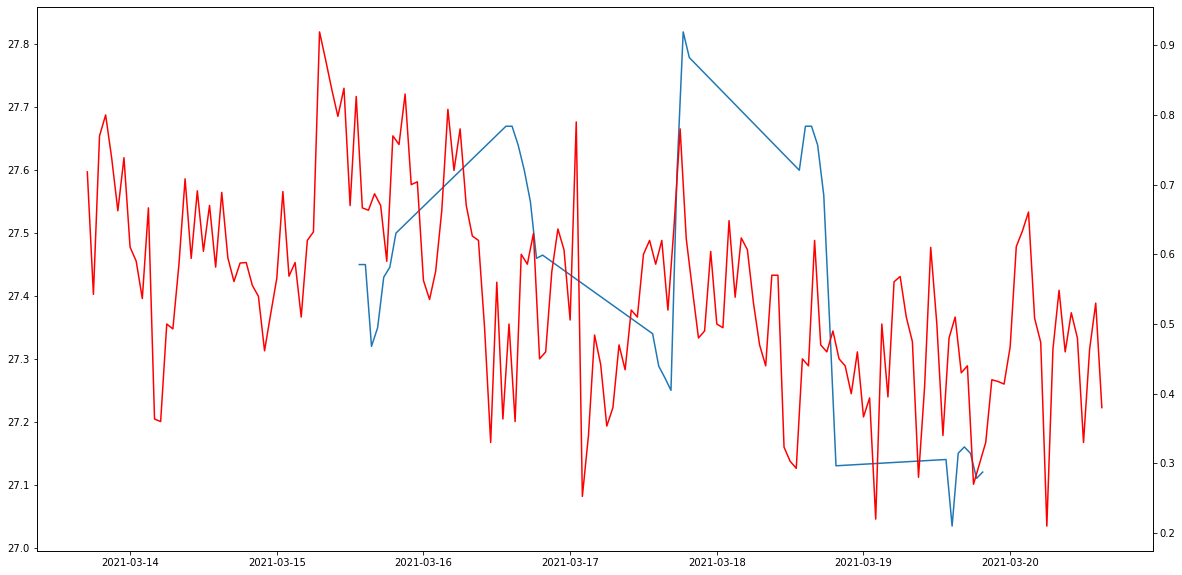

In [75]:
plt.rcParams['figure.figsize']=(20,10) # set the figure size
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # set up the 2nd axis
ax1.plot(drive_etf['High']) 
ax2.plot(df_grouped['positive_ratio'], color='red') 